# Louvain Algorithm implementation

### Implementation

In [1]:
import networkx as nx
from collections import defaultdict
import random

#### 1. Community Tracker

In [2]:
class CommunityTracker:
    """Class to keep track of network statistics of the network as the
    algorithm progresses and nodes move communities.
    """

    def __init__(self):
        self.node_to_community_map = None
        self.m = 0.0
        self.degrees = None
        self.self_loops = None
        self.community_degrees = None
        self.community_self_loops = None

    def initialize_network_statistics(self, G):
        self.node_to_community_map = {}
        self.m = G.size(weight="weight")
        self.degrees = {}
        self.self_loops = {}
        # Sum of the weights of the edges incident to nodes in C.
        self.community_degrees = {}
        # Sum of the weights of the internal edges in C.
        self.community_self_loops = {}
        # Initialize all nodes in separate communities.
        for community, node in enumerate(G):
            self.node_to_community_map[node] = community
            degree = G.degree(node, weight="weight")
            self.degrees[node] = self.community_degrees[community] = degree
            self_loop = 0
            if G.has_edge(node, node):
                self_loop = G[node][node].get("weight", 1)
            self.community_self_loops[community] = self.self_loops[node] = self_loop

    def remove(self, node, community, incident_weight):
        """Removes node from community and updates statistics given the
        incident weight of edges from node to other nodes in community.
        """
        self.community_degrees[community] -= self.degrees[node]
        self.community_self_loops[community] -= incident_weight + self.self_loops[node]
        self.node_to_community_map[node] = None

    def insert(self, node, community, incident_weight):
        """Inserts isolated node into community and updates statistics given
        the incident weight of edges from node to other nodes in community.
        """
        self.community_degrees[community] += self.degrees[node]
        self.community_self_loops[community] += incident_weight + self.self_loops[node]
        self.node_to_community_map[node] = community

#### 2. Louvain class

In [3]:
class Louvain:

    def __init__(self, G, verbose=False, randomized=False):
        # SETTINGS
        self.verbose = verbose
        self.randomized = randomized
        # Create helper to track network statistics.
        # We use the coarse_grain_graph in the iterations.
        self.tracker = CommunityTracker()
        self.original_graph = G
        self.coarse_grain_graph = G
        # self.community_history keeps track of the community maps
        # from each iteration.
        self.community_history = []
        self.iteration_count = 0
        self.finished = False
        # Final community map and list of communities created at end.
        self.community_map = None
        self.communities = None

    def run(self):
        """Runs the iterations of the Louvain method until finished then
        generates the final community map.
        """
        while not self.finished:
            self.iterate()
        if self.verbose:
            print("Finished in {} iterations".format(self.iteration_count))
        self.community_map = self.generate_community_map(
            self.community_history)
        self.communities = self.invert_community_map(self.community_map)
        
    def get_node_neighbours(self, G, node):
        neighbors = []
        for u,v,_ in G.edges(data="weight", default=1):
            if u == node:
                neighbors.append(v)
            elif v == node:
                neighbors.append(u)
        
        return neighbors
    
    def iterate(self):
        """Performs one iteration of the Louvain method on the current graph G.
        For each node we move it to a neighbouring community which causes the
        greatest increase in modularity (if there is no such positive change we
        leave it where it is). We continue this until no more moves can be done
        so we have reached a local modularity optimum.
        We then create a new coarse grained graph where each node represents a
        community for the next iteration.
        """
        self.iteration_count += 1
        if self.verbose:
            print("Iteration: ", self.iteration_count)
        # modified if we have made at least one change overall.
        # improved if we have made at least one change in the current pass.
        modified = False
        improved = True
        G = self.coarse_grain_graph
        self.tracker.initialize_network_statistics(G)
        community_map = self.tracker.node_to_community_map
        
        # queue initialization
        nodes = list(G.nodes())
        if self.randomized:
            nodes = list(G.nodes())
            random.seed()
            random.shuffle(nodes)

        while improved:
            improved = False
            if(len(nodes) == 0):
                break
            for node in nodes:
                best_delta_Q = 0.0
                old_community = community_map[node]
                new_community = old_community
                neighbour_communities = self.get_neighbour_communities(
                    G, node, community_map)
                # Isolate the current node and find the best neighbouring
                # community (including checking the original).
                old_incident_weight = neighbour_communities.get(
                    old_community, 0)
                self.tracker.remove(node, old_community, old_incident_weight)
                for community, incident_wt in neighbour_communities.items():
                    delta_Q = self.calculate_delta_Q(
                        G, node, community, incident_wt)
                    if delta_Q > best_delta_Q:
                        best_delta_Q = delta_Q
                        new_community = community

                # Move to the best community and check if we actually improved.
                new_incident_weight = neighbour_communities[new_community]
                self.tracker.insert(node, new_community, new_incident_weight)
                if self.verbose:
                    message = "Moved node {} from community {} to community {}"
                    print(message.format(node, old_community, new_community))
                    
                nodes.pop()
                
                if new_community != old_community:
                    improved = True
                    modified = True
                    for n in self.get_node_neighbours(G, node):
                        nodes.append(n)
                    

        if modified:
            self.relabel_community_map(community_map)
            self.community_history.append(community_map)
            self.coarse_grain_graph = self.generate_coarse_grain_graph(
                G, community_map)
        if(len(nodes) == 0):
            self.finished = True
            self.improved = False
        else:
            # We didn't modify any nodes so we are finished.
            self.finished = True

#     def iterate(self):
#         """Performs one iteration of the Louvain method on the current graph G.
#         For each node we move it to a neighbouring community which causes the
#         greatest increase in modularity (if there is no such positive change we
#         leave it where it is). We continue this until no more moves can be done
#         so we have reached a local modularity optimum.
#         We then create a new coarse grained graph where each node represents a
#         community for the next iteration.
#         """
#         self.iteration_count += 1
#         if self.verbose:
#             print("Iteration: ", self.iteration_count)
#         # modified if we have made at least one change overall.
#         # improved if we have made at least one change in the current pass.
#         modified = False
#         improved = True
#         G = self.coarse_grain_graph
#         self.tracker.initialize_network_statistics(G)
#         community_map = self.tracker.node_to_community_map

#         while improved:
#             improved = False

#             nodes = G.nodes()
#             if self.randomized:
#                 nodes = list(G.nodes())
#                 random.seed()
#                 random.shuffle(nodes)

#             for node in nodes:
#                 best_delta_Q = 0.0
#                 old_community = community_map[node]
#                 new_community = old_community
#                 neighbour_communities = self.get_neighbour_communities(
#                     G, node, community_map)
#                 # Isolate the current node and find the best neighbouring
#                 # community (including checking the original).
#                 old_incident_weight = neighbour_communities.get(
#                     old_community, 0)
#                 self.tracker.remove(node, old_community, old_incident_weight)
#                 for community, incident_wt in neighbour_communities.items():
#                     delta_Q = self.calculate_delta_Q(
#                         G, node, community, incident_wt)
#                     if delta_Q > best_delta_Q:
#                         best_delta_Q = delta_Q
#                         new_community = community

#                 # Move to the best community and check if we actually improved.
#                 new_incident_weight = neighbour_communities[new_community]
#                 self.tracker.insert(node, new_community, new_incident_weight)
#                 if self.verbose:
#                     message = "Moved node {} from community {} to community {}"
#                     print(message.format(node, old_community, new_community))

#                 if new_community != old_community:
#                     improved = True
#                     modified = True

#         if modified:
#             self.relabel_community_map(community_map)
#             self.community_history.append(community_map)
#             self.coarse_grain_graph = self.generate_coarse_grain_graph(
#                 G, community_map)
#         else:
#             # We didn't modify any nodes so we are finished.
#             self.finished = True

    def get_neighbour_communities(self, G, node, community_map):
        """Returns a dictionary with the neighbouring communities as keys and
        incident edge weights between node and the community as values.
        """
        neighbour_communities = defaultdict(int)
        for neighbour in G[node]:
            if neighbour != node:
                neighbour_community = community_map[neighbour]
                w = G[node][neighbour].get("weight", 1)
                neighbour_communities[neighbour_community] += w
        return neighbour_communities

    def calculate_delta_Q(self, G, node, community, incident_weight):
        """Calculate change in modularity from adding isolated node to
        community."""
        # Sum of the weights of the links incident to nodes in C.
        sigma_tot = self.tracker.community_degrees[community]
        # Sum of the weights of the links incident to node i.
        k_i = self.tracker.degrees[node]
        # Sum of the weights of the links from i to nodes in C.
        k_i_in = incident_weight
        # Sum of the weights of all the links in the network.
        m = self.tracker.m

        delta_Q = 2 * k_i_in - sigma_tot * k_i / m
        return delta_Q
    
    def get_num_edges(self, G, A, B):
        count = 0
        for u, v, w in G.edges(data="weight", default=1):
            if((u in A and v in B) or (v in A and u in B)):
                count += 1
        
        return count
    
    def generate_r(self, C, gamma):
        r = []
        for v in C:
            if(get_num_edges(C.remove(v), v) >= gamma * (len(C) - 1)):
                r.append(r)
        return r        
            

    def generate_coarse_grain_graph(self, G, community_map):
        """Generates new coarse grain graph with each community as a single
        node.
        Weights between nodes are the sum of all weights between respective
        communities and self loops are added for the weights of he internal
        edges.
        """
        new_graph = nx.Graph()
        # Create nodes for each community.
        for community in set(community_map.values()):
            new_graph.add_node(community)
        # Create the combined edges from the individual old edges.
        for u, v, w in G.edges(data="weight", default=1):
            c1 = community_map[u]
            c2 = community_map[v]
            new_weight = w
            if new_graph.has_edge(c1, c2):
                new_weight += new_graph[c1][c2].get("weight", 1)
            new_graph.add_edge(c1, c2, weight=new_weight)
        return new_graph

    def relabel_community_map(self, community_map):
        """Relabels communities to be from 0 to n."""
        community_labels = set(community_map.values())
        relabelled_communities = {j: i for i, j in enumerate(community_labels)}
        for node in community_map:
            community_map[node] = relabelled_communities[community_map[node]]

    def invert_community_map(self, community_map):
        """Inverts a community map from nodes to communities to a list of
        lists of nodes where each list of nodes represents one community.
        """
        inverted_community_map = defaultdict(list)
        for node in community_map:
            inverted_community_map[community_map[node]].append(node)
        return list(inverted_community_map.values())

    def generate_community_map(self, community_history):
        """Builds the final community map using the history of iterations."""
        community_map = {node: node for node in self.original_graph}
        for node in community_map:
            for iteration in community_history:
                # Follow iterations to find final community of node.
                community_map[node] = iteration[community_map[node]]
        return community_map


def detect_communities(G, verbose=False, randomized=False):
    """Returns the detected communities as a list of lists of nodes
    representing each community.
    Uses the Louvain heuristic from:
        Blondel, V.D. et al. Fast unfolding of communities in
    large networks. J. Stat. Mech 10008, 1 - 12(2008).
    """
    louvain = Louvain(G, verbose=verbose, randomized=randomized)
    louvain.run()
    return louvain.communities

#### 3. Modularity 

In [4]:
from itertools import product

def modularity(G, partition):
    """Returns the modularity of the partition of an undirected graph G.
    Definition as given in:
        M. E. J. Newman. Networks: An Introduction, page 224.
    Oxford University Press, 2011.
    """
    m = G.size(weight="weight")
    degrees = dict(G.degree(weight="weight"))
    Q = 0
    for community in partition:
        for u, v in product(community, repeat=2):
            try:
                w = G[u][v].get("weight", 1)
            except KeyError:
                w = 0
            if u == v:
                # Double count self-loop weight.
                w *= 2
            Q += w - degrees[u] * degrees[v] / (2 * m)
    return Q / (2 * m)

### Example

In [5]:
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

In [6]:
def draw_communities(G, node_size=30, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

Modularity for best partition: 0.24416502301117696
0.06670390000002158


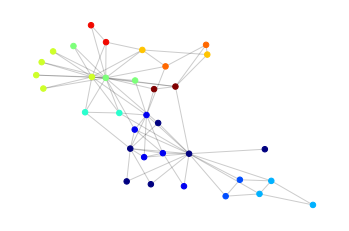

In [14]:
G = nx.karate_club_graph()
start = timeit.default_timer()
draw_communities(G)
end = timeit.default_timer()
print(end - start)

In [8]:
lauvin = Louvain(G)

In [9]:
i = lauvin.get_num_edges(G, [0,1,2], [3,4,5])
i

5

In [10]:
arr = lauvin.get_node_neighbours(G,0)
arr

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]

In [11]:
import timeit

In [12]:
start = timeit.default_timer()
lauvin.run()
end = timeit.default_timer()
print(end - start)
com = lauvin.communities

0.01168599999999742


In [13]:
com

[[0, 1, 11, 17, 19, 21],
 [2, 3, 7, 12, 13],
 [4, 10],
 [5, 6, 16],
 [8, 30],
 [9, 20, 33],
 [14, 15, 18, 22, 32],
 [23, 25],
 [24, 27],
 [26, 29],
 [28, 31]]

## Tests

### Karate

Graph with 34 nodes and 78 edges


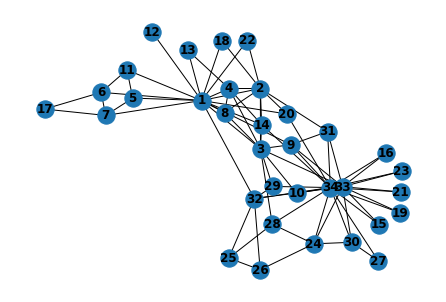

In [15]:
G1 = nx.read_gml('./dataset/karate/karate.gml', label='id')
print (nx.info(G1))
nx.draw(G1, with_labels=True, font_weight='bold')

Modularity for best partition: 0.24416502301117696
Time 0.05473910000000615


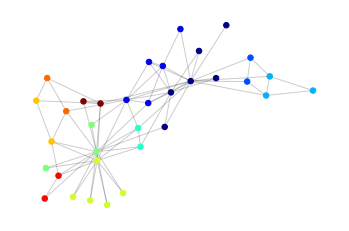

In [16]:
start = timeit.default_timer()
draw_communities(G1)
end = timeit.default_timer()
print("Time",end - start)

## Dolphins

Graph with 62 nodes and 159 edges


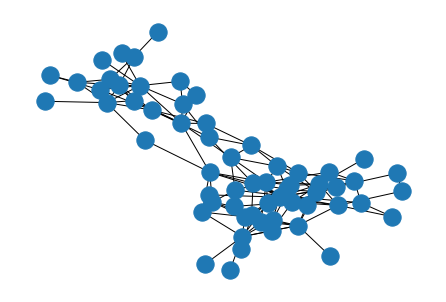

In [17]:
G2 = nx.read_gml('./dataset/dolphins/dolphins.gml', label='label')
print (nx.info(G2))
nx.draw(G2, with_labels=False, font_weight='light')

Modularity for best partition: 0.49895178197064943
Time 0.09222699999997985


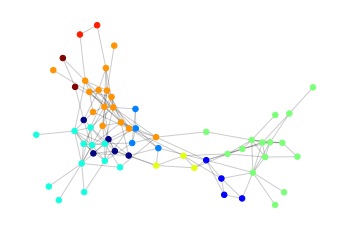

In [18]:
start = timeit.default_timer()
draw_communities(G2)
end = timeit.default_timer()
print("Time",end - start)

## Ressources

* https://github.com/tzyl/louvain-communities
* https://github.com/riyadparvez/louvain-method
* https://www.youtube.com/watch?v=-VAvUgzey3I&ab_channel=D%C3%A1vidNyerges